# Result summary

Basically the results of this simulation can be summarized as follows:
* **Too many goals** Low death rate, low economic impact and a stable health system are not attainable, no matter what matters are chosen. One of three goals need to be dropped.
* **The Hammer, the Dance and Groundhog days** early release of social distancing measures create repeated infection waves.

* **Social distancing** is the most powerful prevention tool for reducing death rates, ensuring stable health system but causes economic losses.
* **Immune pass** is not a relevant measure at the scales tested in these simulations. Given the stochastics of these processes and the relevance of social distancing measures, effects of the immune pass pale in comparison.
* **Corona parties** that are held in cycles longer than every 8 days don't have a macroscopic effect on the turnout of the simulations. Effects of other measures are much stronger in comparison
* **Testing to verify who has recovered** (has already been infected at some point) is not really relevant as the immune pass essentially does not work. Or is insignificant.
* **Testing to verify who is sick** has a strong positive effect on ensuring social distancing is effective. Still, having a high testing rate ensures that the desease run's longer, because the pool of uninfected (hence potentially sick) people stays larger for a long time.

For a deeper discussion on key factors visit see [Notebook on key factors of death rate, economic loss and health system stress levels](corona_sim_key_variables.ipynb)

**Short outline**

* **Death rate**: The majority of the death rate is determined by **R_SPREAD_MULT_FATALITY**, i.e., Infectiousness x Fatality of desease. So the more infectious and the more deadly the higher the death rate. Not very surprising.
* **Economic loss**: The majority of the economic loss is determined by **KNOW_RATE_SICK_MULT_SD_IMPACT**, i.e., Sick testing x Strength of social distancing. So the more we test and the stronger we distance socially the higher the economic loss will be.
* **Health system stress**: The majority of the health system stress (sick peak) is determined by **KNOW_RATE_SICK_MULT_SD_IMPACT**, i.e., Sick testing x Strength of social distancing. So the more we test and the stronger we distance socially the lower the stress on the health system will be, i.e., the maximal number of people sick will be lower. Another minor factor is **SD_IMPACT_DIV_SD_START**, i.e., social distancing strength divided by onset of social distancing. The earlier and stronger social distancing starts, the lower is the overall stress on the health system.

#### Major open considerations for next version of the simulation

* Currently, the death rate is mostly independent of the social measures taken, which is counterintuitive at first glance. Still, not surprising because death is simulated by throwing a coin with certain likelihood at the end of the disease. One would need to link higher health system stress with higher death rates, which is currently not simulated.
* Corona parties and immune pass seem to have only minor influence on economic loss, death rates and health system stress. Initial analyses indicate that those measures have the largest effects in situations where social distancing is extremely aggressive and might balance these effects. Unfortunately, there are only ~2.8k of the 200k simulations that have very aggressive social distancing (**KNOW_RATE_SICK_MULT_SD_IMPACT** > 0.9). One would need to simulate more of these scenarios to get a better feeling of how immune pass and corona parties influence these long tail simulations.

## Prepare analyses

#### Load data

In [1]:
import pandas
import plotly.express as px
import plotly.graph_objects as go
import numpy as np
import hist2d
import plotly.io as pio
from IPython.display import Image

df = pandas.read_pickle("../data/stats.xz")
df.drop(df[df["RUN"] != 2].index, axis=0, inplace=True)
df.reset_index(inplace=True)

In [2]:
df.shape

(213308, 25)

#### Correct economic impact to make it comparable across scenarios

In [3]:
maxd = np.max(df["DURATION"].values)
df["WORKING"] = (maxd - df["DURATION"]) * df["DEATH"] + df["WORKING"]
df["WORKING"] = np.log10(df["WORKING"]/(maxd*df["NUM_AGENTS"]))

#### Generate function to visualize death vs. economic loss (for interactive version and not static graphs uncomment here)

In [4]:
def show_results(hist, w_steps, d_steps, colorbar):
    c_vals = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6]

    fig = go.Figure(data=go.Heatmap(z=hist, x=w_steps, y=d_steps, hoverongaps = False, colorbar = colorbar))
    x_vals = [0.01, 0.025, 0.05, 0.1, 0.15, 0.2, 0.3, 0.4, 0.5]
    y_vals = [0.01, 0.05, 0.1, 0.15, 0.2]

    fig.update_layout(
        xaxis = dict(
            tickmode = 'array',
            tickvals = [np.log10(v) for v in x_vals],
            ticktext = [f"{v *100:.0f} %" for v in x_vals],
            title = "Total workhours lost [%]"
        ),
        yaxis = dict(
            tickmode = 'array',
            tickvals = y_vals,
            ticktext = [f"{v *100} %" for v in y_vals],
            title = "People died [%]"
        )
    )
    #uncomment to get static version
    return Image(pio.to_image(fig, format='png'))
    #uncomment to get interactive version
    #fig.show()

## Too many goals

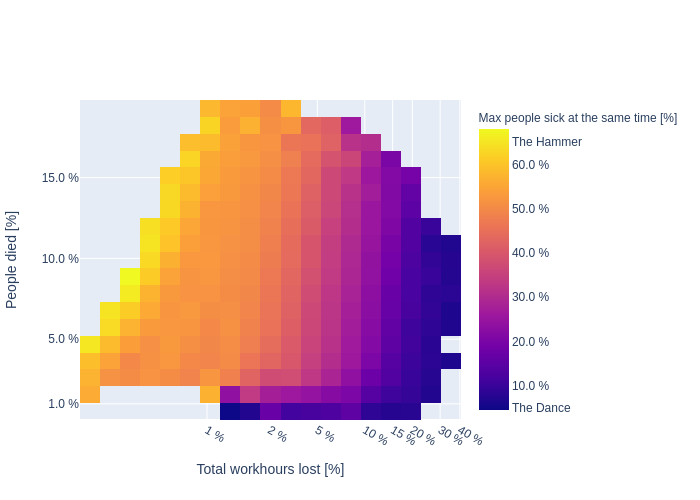

In [5]:
hist, d_steps, w_steps = hist2d.get2d_hist(df, bins=20, x="DEATH", y="WORKING", z="SICK_PEAK", reduce_op=np.mean)
c_vals = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6]
colorbar = dict(title="Max people sick at the same time [%]", tickvals=[0.05] +  c_vals + [0.65],
                ticktext=["The Dance"] + [f"{v *100} %" for v in c_vals] + ["The Hammer"])
show_results(hist, w_steps, d_steps, colorbar)

This graph indicates that the flatter the infection curve (more blue) the more work hours are lost and fewer people die. It also shows that the scenarios with the few work hours lost are also those heaviest (more orange/yellow) to the health system.

## Groundhog days

Let's take a look on how long these scenarios typically last

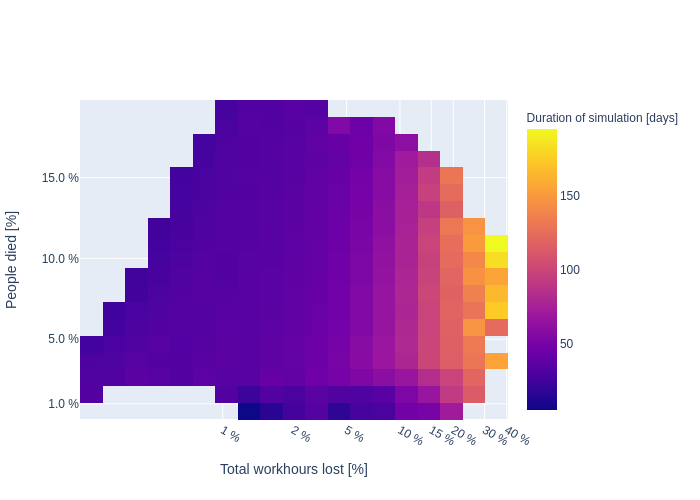

In [6]:
hist, d_steps, w_steps = hist2d.get2d_hist(df, bins=20, x="DEATH", y="WORKING", z="DURATION", reduce_op=np.median)
colorbar = dict(title="Duration of simulation [days]")
show_results(hist, w_steps, d_steps, colorbar)

As expected the duration is inverse to the stress on the health system. Longer durations often go along with higher loss of workhours but have a lower death count.

Even though this seems counter-intuitive at first. Looking in depth on simulations that are further on the right, show that the reason is, that the number of desease waves increases the further you are on the right side.

![title](corona_sim.png)

Once social distancing kicks in the number of cases drops rapidly. If social distancing is released before sick agents drop to 0, the desease keeps on spreading until some level of herd immunity is reached.

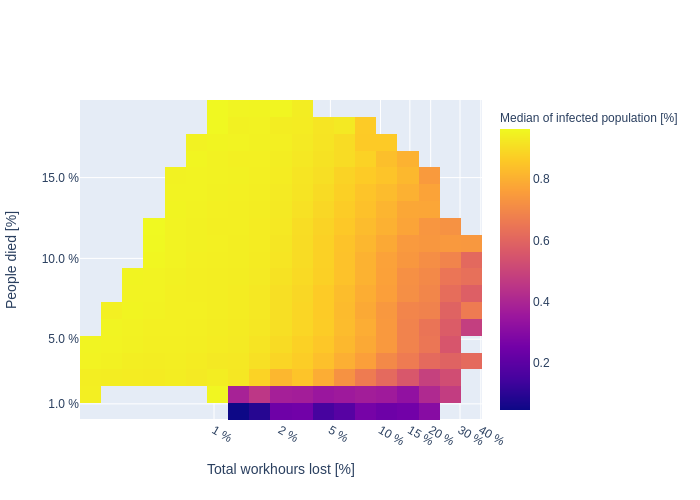

In [7]:
hist, d_steps, w_steps = hist2d.get2d_hist(df, bins=20, x="DEATH", y="WORKING", z="INFECTED", reduce_op=np.median)
colorbar = dict(title="Median of infected population [%]")
show_results(1 - hist, w_steps, d_steps, colorbar)

Evidently, on the left side the majority of the population has been infected in most of the simulations. Only, when going to the right side, fewer people have actually got infected. But even in the far right cases, 50 - 60% of the population got infected. overall the far right simulations cap the death rate around 12.5% of the population.

On the rather right side of these simulations an effective herd immunity is created. That means even though herd immunity is not fully established yet, the spacial distribution of the agents allows to keep $R_{spread}$ (in red) bouncing around 1 and keeping the epidemic at bay. Eventually, #sick agents (in blue) goes down.

![title](simulation_early_herd_immunity.png)

## Effects of different measures

### 2.c.ii Social distancing

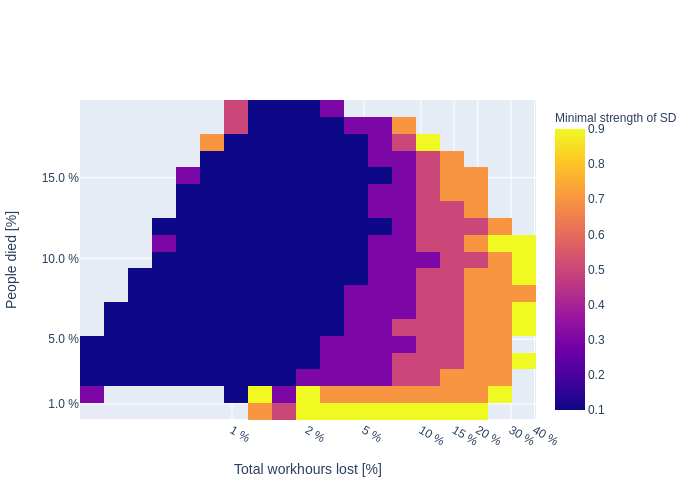

In [8]:
hist, d_steps, w_steps = hist2d.get2d_hist(df, bins=20, x="DEATH", y="WORKING", z="SD_IMPACT", reduce_op=np.min)
colorbar = dict(title="Minimal strength of SD")
show_results(hist, w_steps, d_steps, colorbar)

One can clearly see from this graph, that the stronger social distancing works, the longer the desease will take and the more workhours will be lost. Overall The strength of social distancing does not significantly affect death_rates.

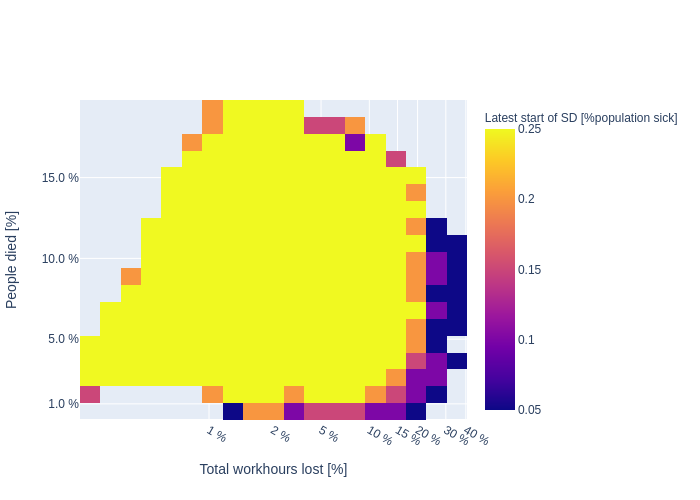

In [9]:
hist, d_steps, w_steps = hist2d.get2d_hist(df, bins=20, x="DEATH", y="WORKING", z="SD_START", reduce_op=np.max)
colorbar = dict(title="Latest start of SD [%population sick]")
show_results(hist, w_steps, d_steps, colorbar)

So how long can you actually wait with starting social distancing. Actually pretty long. The graph suggests that for the majority of cases, one can wait even until 25% of the population are sick. Only to get to the far right side (long duration, low stress for health sector) one needs really early social distancing (e.g., 0.05% of the population need to be sick for social distancing to kick-in). 

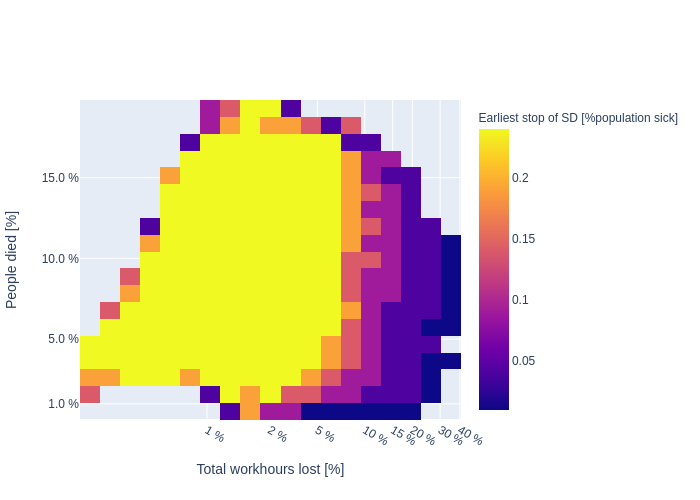

In [10]:
hist, d_steps, w_steps = hist2d.get2d_hist(df, bins=20, x="DEATH", y="WORKING", z="SD_STOP", reduce_op=np.max)
colorbar = dict(title="Earliest stop of SD [%population sick]")
show_results(hist, w_steps, d_steps, colorbar)

Interestingly, the time (or the level of sick people) when to stop social distancing is a much stronger predictor of the duration and level of economic loss. The earlier social distancing is stopped the shorter will the desease run, still with higher stress on the health system.

### 2.c.i Effectiveness of testing, i.e., knowing how much people are actually sick

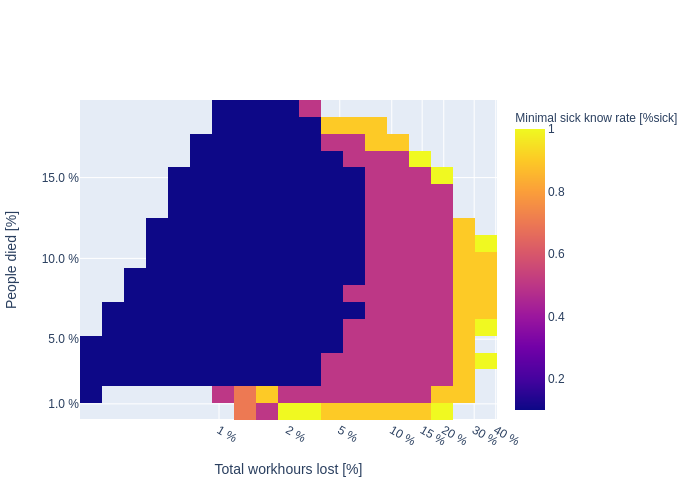

In [11]:
hist, d_steps, w_steps = hist2d.get2d_hist(df, bins=20, x="DEATH", y="WORKING", z="KNOW_RATE_SICK", reduce_op=np.min)
colorbar = dict(title="Minimal sick know rate [%sick]")
show_results(hist, w_steps, d_steps, colorbar)

In the current model, the better we test and therefore know the true number of sick agents, the earlier social distancing will kick-in and the earlier it will be released. Unfortunately, this means, the more we know, the longer will the desease last. Of course, the fewer people will get sick and die.

### 2.c.iii Immune pass

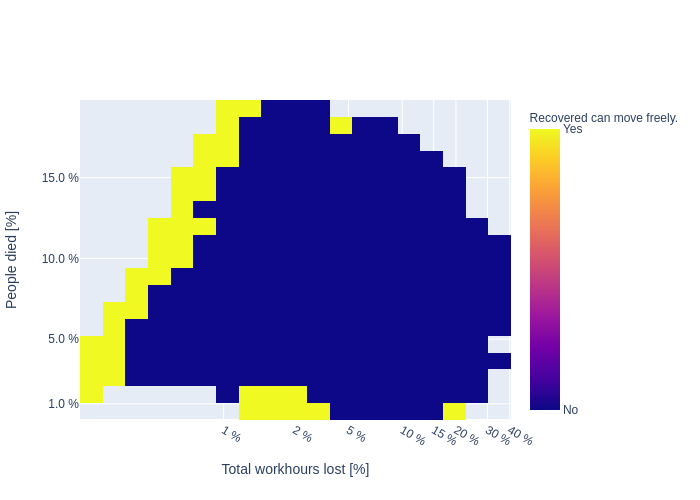

In [12]:
hist, d_steps, w_steps = hist2d.get2d_hist(df, bins=20, x="DEATH", y="WORKING", z="SD_RECOVERED", reduce_op=np.min)
colorbar = dict(title="Recovered can move freely.", tickmode = 'array', tickvals = [0, 1], ticktext = ["No", "Yes"])
show_results(hist, w_steps, d_steps, colorbar)

As expected, the immune pass is a measure that speeds up economic recovery. For a given death rate, the minimal loss in total workhours is only achievable if the immune pass measure is active.

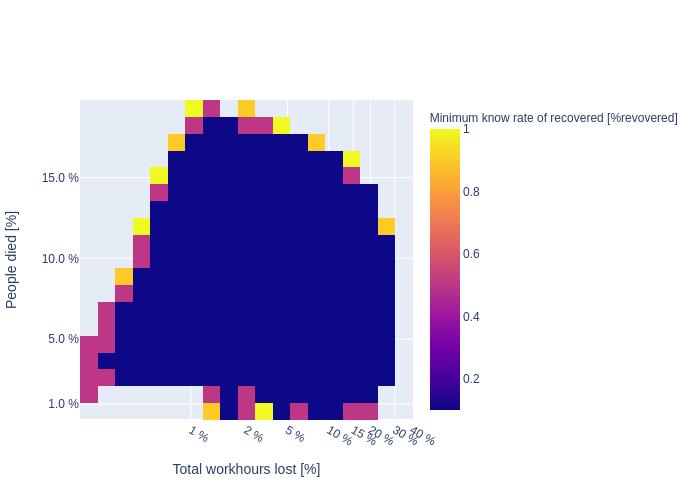

In [13]:
df_recov = df[df["SD_RECOVERED"] == 1]
df_recov.reset_index(inplace=True)
hist, d_steps, w_steps = hist2d.get2d_hist(df_recov, bins=20, x="DEATH", y="WORKING", z="KNOW_RATE_RECOVERED", reduce_op=np.min)
colorbar = dict(title="Minimum know rate of recovered [%revovered]")
show_results(hist, w_steps, d_steps, colorbar)

Given the above graph. One can clearly see, that the immune pass is not a relevant factor. At least not in the simulations sizing. Other factors like SD_IMPACT, SD_START, SD_STOP have a much bigger influence and also the stochastics allow to achieve most of these quadrants whether or not the immune pass is active.

### 2.c.iv Corona parties

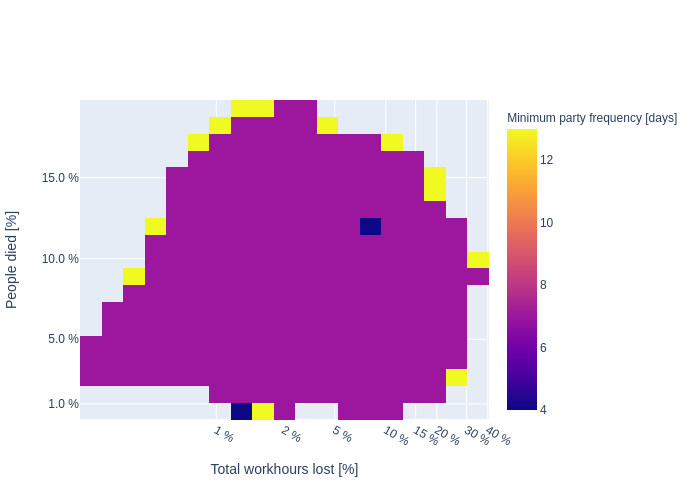

In [14]:
df_party =  df[df["PARTY_FREQ"] > 0]
df_party.reset_index(inplace=True)
hist, d_steps, w_steps = hist2d.get2d_hist(df_party, bins=20, x="DEATH", y="WORKING", z="PARTY_FREQ", reduce_op=np.min)
colorbar = dict(title="Minimum party frequency [days]")
show_results(hist, w_steps, d_steps, colorbar)

This graph shows that a party frequency of around 8 (i.e., party every 8 days) does not have any impact on where you will land in the death-rate/workhour matrix.

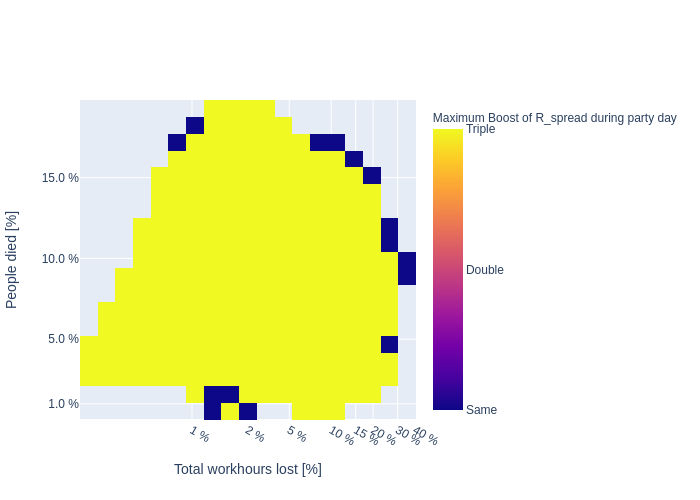

In [15]:
hist, d_steps, w_steps = hist2d.get2d_hist(df_party, bins=20, x="DEATH", y="WORKING", z="PARTY_R_BOOST", reduce_op=np.max)
colorbar = dict(title="Maximum Boost of R_spread during party day", tickmode="array", tickvals=[1, 2, 3, 4, 5],
                ticktext=["Same", "Double", "Triple", "Quadruple", "5x"])
show_results(hist, w_steps, d_steps, colorbar)

Similarly, you could even triple the deseases contagiousness (R), it would not have a statistical influence on where you would land in this matrix.

In [16]:
sub_df.reset_index(inplace=True)
hist, d_steps, w_steps = hist2d.get2d_hist(sub_df, bins=20, x="DEATH", y="WORKING", z="NUM_AGENTS", reduce_op=np.median)

fig = go.Figure(data=go.Heatmap(z=hist, x=w_steps, y=d_steps, hoverongaps = False,
                colorbar = dict(title="SD_impact")
                               )
               )
#fig = go.Figure(data=go.Scatter(y=sub_df["DEATH"], x=sub_df["WORKING"], mode='markers'))

x_vals = [0.01, 0.025, 0.05, 0.1, 0.15, 0.2, 0.3, 0.4, 0.5]
y_vals = [0.01, 0.05, 0.1, 0.15, 0.2]

fig.update_layout(
    xaxis = dict(
        tickmode = 'array',
        tickvals = [np.log10(v) for v in x_vals],
        ticktext = [f"{v *100:.0f} %" for v in x_vals],
        title = "Total workhours lost [%]"
    ),
    yaxis = dict(
        tickmode = 'array',
        tickvals = y_vals,
        ticktext = [f"{v *100} %" for v in y_vals],
        title = "People died [%]"
    )
)

fig.show()


NameError: name 'sub_df' is not defined